# Makeup Recommender
Ananya Nadendla, Gursimar Singh


---



> Makeup Recomender recommends similar makeup products based on the user's chosen product. This project helps find hidden qualities past just basic product types (i.e creamy lipsticks, instead of just lipsticks).



---



### 1. Normalization and Preprocessing



**Load in 4 Makeup Datasets**

In [60]:
#imports
%pip install pandas numpy matplotlib ipywidgets scikit-learn scipy openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, HTML
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import scipy.sparse as sp
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# datasets
sephoraDS = pd.read_csv("data/product_info.csv")
lipDS     = pd.read_excel("data/lipstick_products.xlsx")
faceDS    = pd.read_excel("data/face_products.xlsx")
eyeDS     = pd.read_excel("data/eye_products.xlsx")

#print statements for debugging
print(" ~~~~~ DATASETS LOADED ~~~~~")
print(f"Sephora rows, cols: {sephoraDS.shape}")
print(f"Lip rows, cols:     {lipDS.shape}")
print(f"Face rows, cols:    {faceDS.shape}")
print(f"Eye rows, cols:     {eyeDS.shape}")

print("\nSephora columns:", list(sephoraDS.columns), "...")
print("Lip columns:    ", list(lipDS.columns), "...")
print("Face columns:   ", list(faceDS.columns), "...")
print("Eye columns:    ", list(eyeDS.columns), "...")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


 ~~~~~ DATASETS LOADED ~~~~~
Sephora rows, cols: (8494, 27)
Lip rows, cols:     (2090, 31)
Face rows, cols:    (3482, 31)
Eye rows, cols:     (3280, 31)

Sephora columns: ['product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count', 'rating', 'reviews', 'size', 'variation_type', 'variation_value', 'variation_desc', 'ingredients', 'price_usd', 'value_price_usd', 'sale_price_usd', 'limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive', 'highlights', 'primary_category', 'secondary_category', 'tertiary_category', 'child_count', 'child_max_price', 'child_min_price'] ...
Lip columns:     ['sku', 'upc', 'asin', 'size', 'color', 'price', 'country', 'summary', 'uniq_id', 'currency', 'site_name', 'brand_name', 'category_1', 'category_2', 'category_3', 'highlights', 'how_to_use', 'product_id', 'breadcrumbs', 'description', 'ingredients', 'product_url', 'availability', 'last_updated', 'product_name', 'original_price', 'raw_how_to_use', 'raw_description', 'raw_ingred

Standardize columns across all 4 datasets to have same names

In [61]:
def standardize_columns(df, source):
    #renaming colums so they  have all same col nams
    rename_dict = {
        'product_name': 'product_name',
        'brand_name': 'brand',

        'description': 'description',

        'ingredients': 'ingredients',

        'price': 'price',
        'price_usd': 'price',
        'primary_category': 'category_1',
        'secondary_category': 'category_2',
        'tertiary_category': 'category_3',
        'category_1': 'category_1',
        'category_2': 'category_2',
        'category_3': 'category_3',
    }

    #rename columns based on the mapping above
    df = df.rename(columns=rename_dict)
    #Keep all necessary cols,
    for col in ['product_name','brand','description','ingredients','price','category_1','category_2','category_3']:
        if col not in df.columns:
            df[col] = None # add missing cols for consistency
    df['source'] = source # track og datsts
    return df

#Standarization
sephoraDS = standardize_columns(sephoraDS,"sephora")
lipDS     = standardize_columns(lipDS,"lip")
faceDS    = standardize_columns(faceDS,"face")
eyeDS     = standardize_columns(eyeDS,"eye")

#debugging
print("~~~~~ AFTER STANDARDIZING COLUMNS ~~~~~")
print("Sephora columns:", list(sephoraDS.columns))
print("\nLip columns:    ", list(lipDS.columns))
print("\nFace columns:   ", list(faceDS.columns))
print("\nEye columns:    ", list(eyeDS.columns))

~~~~~ AFTER STANDARDIZING COLUMNS ~~~~~
Sephora columns: ['product_id', 'product_name', 'brand_id', 'brand', 'loves_count', 'rating', 'reviews', 'size', 'variation_type', 'variation_value', 'variation_desc', 'ingredients', 'price', 'value_price_usd', 'sale_price_usd', 'limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive', 'highlights', 'category_1', 'category_2', 'category_3', 'child_count', 'child_max_price', 'child_min_price', 'description', 'source']

Lip columns:     ['sku', 'upc', 'asin', 'size', 'color', 'price', 'country', 'summary', 'uniq_id', 'currency', 'site_name', 'brand', 'category_1', 'category_2', 'category_3', 'highlights', 'how_to_use', 'product_id', 'breadcrumbs', 'description', 'ingredients', 'product_url', 'availability', 'last_updated', 'product_name', 'original_price', 'raw_how_to_use', 'raw_description', 'raw_ingredients', 'additional_images', 'primary_image_url', 'source']

Face columns:    ['sku', 'upc', 'asin', 'size', 'color', 'price', 

Standardize pricing to numeric numbers.

In [62]:
#fixes string prices, etc to standardized numbers.
def fix_price(df, name=""):
    df = df.copy() # so we don't accidentally change og data
    print(f"\n~~~~~ PRICE CLEANING: {name} ~~~~~")
    #Debugging comments

    #remove $ and , from price col
    df['price'] = (
        df['price'].astype(str)
        .str.replace('$','',regex=False)
        .str.replace(',','',regex=False)
        .str.strip()
    )
    # change string to numeric
    df['price'] = pd.to_numeric(df['price'], errors='coerce') #remove missing/impossible values

    before_rows = len(df) # track row count
    df = df[df['price'].notna()]
    df = df[df['price'] > 0]
    df = df[df['price'] <= 500]
    after_rows = len(df)

    print(f"Rows before price filter: {before_rows}, after: {after_rows}")

    return df

#apply clean pricing to datasets
sephoraDS = fix_price(sephoraDS, "Sephora")
lipDS     = fix_price(lipDS, "Lip")
faceDS    = fix_price(faceDS, "Face")
eyeDS     = fix_price(eyeDS, "Eye")


~~~~~ PRICE CLEANING: Sephora ~~~~~
Rows before price filter: 8494, after: 8493

~~~~~ PRICE CLEANING: Lip ~~~~~
Rows before price filter: 2090, after: 2090

~~~~~ PRICE CLEANING: Face ~~~~~
Rows before price filter: 3482, after: 3133

~~~~~ PRICE CLEANING: Eye ~~~~~
Rows before price filter: 3280, after: 2350


Remove rows with important info missing (product name, brand, price)

In [63]:
#get rid of rows w/ important info missing
def clean_missing(df, name=""):
    df = df.copy() # another copy
    before = len(df) # number of rows before cleaning

    #count missing fields for important cols
    missing_prod = df['product_name'].isna().sum()
    missing_brand = df['brand'].isna().sum()
    missing_price = df['price'].isna().sum()

    #debugging
    print(f"\n~~~~~ Summary of Missing Info BEFORE dropna FOR {name} ~~~~~")
    print(f"Rows: {before}, missing product_name: {missing_prod}, missing brand: {missing_brand}, missing price: {missing_price}")

    #remove rows with missing items
    df = df.dropna(subset=['product_name','brand','price'])

    #if descriptoin or ingredients missing, fill w/ empty strings
    df['description'] = df['description'].fillna('')
    df['ingredients'] = df['ingredients'].fillna('')
    after = len(df) # nukber of rows left
    print(f"# of Rows after dropping rows that miss important fields: {after}")
    return df

# store og row counts for visualization later
sephora_before = len(sephoraDS)
lip_before     = len(lipDS)
face_before    = len(faceDS)
eye_before     = len(eyeDS)

#fix datasets after cleaning
sephoraDS = clean_missing(sephoraDS, "Sephora")
lipDS     = clean_missing(lipDS, "Lip")
faceDS    = clean_missing(faceDS, "Face")
eyeDS     = clean_missing(eyeDS, "Eye")

print("\n~~~~~ ROW COUNTS AFTER clean_missing ~~~~~")
print("Sephora:", len(sephoraDS))
print("Lip:    ", len(lipDS))
print("Face:   ", len(faceDS))
print("Eye:    ", len(eyeDS))


~~~~~ Summary of Missing Info BEFORE dropna FOR Sephora ~~~~~
Rows: 8493, missing product_name: 0, missing brand: 0, missing price: 0
# of Rows after dropping rows that miss important fields: 8493

~~~~~ Summary of Missing Info BEFORE dropna FOR Lip ~~~~~
Rows: 2090, missing product_name: 0, missing brand: 0, missing price: 0
# of Rows after dropping rows that miss important fields: 2090

~~~~~ Summary of Missing Info BEFORE dropna FOR Face ~~~~~
Rows: 3133, missing product_name: 0, missing brand: 25, missing price: 0
# of Rows after dropping rows that miss important fields: 3108

~~~~~ Summary of Missing Info BEFORE dropna FOR Eye ~~~~~
Rows: 2350, missing product_name: 0, missing brand: 0, missing price: 0
# of Rows after dropping rows that miss important fields: 2350

~~~~~ ROW COUNTS AFTER clean_missing ~~~~~
Sephora: 8493
Lip:     2090
Face:    3108
Eye:     2350


Sephora dataset does not have a description field. Creating one from other columns.

In [64]:
def create_sephora_description(df):
    df = df.copy() #another copy

    #replace missing fields with empty string
    df['highlights']  = df['highlights'].fillna('')
    for c in ['category_1','category_2','category_3']:
        if c in df.columns:
            df[c] = df[c].fillna('')

    #making a description using product name, highlights, categories
    df['description'] = (
        # df['product_name'].astype(str) + " " +   #removing bcuz brands are domianting SVD concepts
        df['highlights'].astype(str) + " " +
        df['category_1'].astype(str) + " " +
        df['category_2'].astype(str) + " " +
        df['category_3'].astype(str)
    ).str.strip() # removing extra spaces


    return df


#debugging
print("~~~~~ SEPHORA DESCRIPTION (BEFORE) ~~~~~")
print(sephoraDS[['product_name','highlights','category_1','category_2','category_3','ingredients']].head(5))

sephoraDS = create_sephora_description(sephoraDS) #call func

print("\n~~~~~ SEPHORA DESCRIPTION (AFTER) ~~~~~")
print(sephoraDS[['product_name','description']].head(5))

#checking for missing descriptions, should be zero
print("\nMissing descriptions in Sephora after building:",
      sephoraDS['description'].isna().sum(),
      " / ", len(sephoraDS))

~~~~~ SEPHORA DESCRIPTION (BEFORE) ~~~~~
                product_name  \
0    Fragrance Discovery Set   
1    La Habana Eau de Parfum   
2  Rainbow Bar Eau de Parfum   
3       Kasbah Eau de Parfum   
4  Purple Haze Eau de Parfum   

                                          highlights category_1  \
0  ['Unisex/ Genderless Scent', 'Warm &Spicy Scen...  Fragrance   
1  ['Unisex/ Genderless Scent', 'Layerable Scent'...  Fragrance   
2  ['Unisex/ Genderless Scent', 'Layerable Scent'...  Fragrance   
3  ['Unisex/ Genderless Scent', 'Layerable Scent'...  Fragrance   
4  ['Unisex/ Genderless Scent', 'Layerable Scent'...  Fragrance   

          category_2         category_3  \
0  Value & Gift Sets  Perfume Gift Sets   
1              Women            Perfume   
2              Women            Perfume   
3              Women            Perfume   
4              Women            Perfume   

                                         ingredients  
0  ['Capri Eau de Parfum:', 'Alcohol Denat. (SD A

Remove sets, bundles, and kits:

In [65]:
# remove these words 12/7
drop_keywords = [
    "gift sets",
    "sets",
    "set",
    "value",
    "value gift",
    "bundles",
    "accessories",
    "brush sets",
    "kit",
    "kits"
]

# removes products containing any of the drop keywords
def drop_products(df, dataset_name):
    df_before = len(df)
    # build mask for any keyword match
    mask = df['product_name'].str.lower().str.contains("|".join(drop_keywords), na=False)

    # Products that will be dropped ( debugging)
    to_drop = df.loc[mask, 'product_name']

    print(f"\n~~~~~ {dataset_name} PRODUCTS TO DROP ~~~~~")
    print(to_drop.head(20))
    print(f"Total flagged to drop: {mask.sum()}")

    # Drop rows
    df = df[~mask].copy()
    df.reset_index(drop=True, inplace=True)

    print(f"{dataset_name} rows before: {df_before}, after removal: {len(df)}")
    return df

# apply
lipDS     = drop_products(lipDS, "Lip")
faceDS    = drop_products(faceDS, "Face")
eyeDS     = drop_products(eyeDS, "Eye")
sephoraDS = drop_products(sephoraDS, "Sephora")



~~~~~ Lip PRODUCTS TO DROP ~~~~~
36                            Matte Lip Kit - 300 Koko K
38                           Matte Lip Kit - 802 Candy K
55                    Soft Touch Lipstick - Sunset Dance
83                    Soft Touch Lipstick - Sunset Dance
95                    Soft Touch Lipstick - Sunset Dance
102    My Heart Beats Disco Glitter Switch Liquid Lip...
129                             Matte Lip Kit - 700 Bare
143        Soft Blur Matte Lipstick - Little Red Rosette
188                    Lip Blush Kit - 729 Sister Sister
226                            Velvet Lip Kit - 700 Bare
326    Pure Color Explicit Slick Shine Lipstick - Sco...
339                   Soft Touch Lipstick - Sunset Dance
341                           Ultra Blotted Lip - Kitten
347                            Matte Lip Kit - 301 Angel
384                          Matte Lip Kit - 100 Posie K
443                  Matte Lip Kit - 704 Sweater Weather
470                   Soft Touch Lipstick - Sunset Dan

Dropping certain category types that are non-makeup related:

In [66]:
# Categories to drop
drop_categories = [
    "skincare",
    "skin care",
    "hair",
    "bath & body",
    "fragrance",
    "candles",
    "tools & brushes",
    "accessories",
    "brushes & applicators",
    "nail",
    "men",
    "mini size"
]

def drop_by_category(df, dataset_name):
    df_before = len(df)

    # lowercase for case-insensitive matching
    cat1 = df['category_1'].astype(str).str.lower()
    cat2 = df['category_2'].astype(str).str.lower()

    # mask rows to drop if either category matches
    mask = cat1.isin(drop_categories) | cat2.isin(drop_categories)

    # debug: showing sample rows that will be dropped
    print(f"\n~~~~~ {dataset_name} PRODUCTS IN DROPPED CATEGORIES ~~~~~")
    print(df.loc[mask, ['product_name', 'category_1', 'category_2']].head(15))
    print(f"Total products to drop: {mask.sum()}")

    # keep only rows not flagged
    df = df[~mask].copy()
    df.reset_index(drop=True, inplace=True)

    after = len(df)
    print(f"{dataset_name} rows before: {df_before}, after removal: {after}")
    return df

# Apply to all datasets
lipDS     = drop_by_category(lipDS, "Lip")
faceDS    = drop_by_category(faceDS, "Face")
eyeDS     = drop_by_category(eyeDS, "Eye")
sephoraDS = drop_by_category(sephoraDS, "Sephora")



~~~~~ Lip PRODUCTS IN DROPPED CATEGORIES ~~~~~
Empty DataFrame
Columns: [product_name, category_1, category_2]
Index: []
Total products to drop: 0
Lip rows before: 2035, after removal: 2035

~~~~~ Face PRODUCTS IN DROPPED CATEGORIES ~~~~~
                                         product_name category_1 category_2
1   Press Refresh by ZitSticka, Exfoliating and Hy...     Beauty  Skin Care
4   NIVEA Q10 + C Power Anti-Wrinkle + Energy Shee...     Beauty  Skin Care
5   U Beauty Resurfacing Compound Serum - Renew & ...     Beauty  Skin Care
6   PLAFOPE 70pcs Beauty Gauze Facial Masks Face S...     Beauty  Skin Care
7   Skin Scrubber Face Spatula,Portable Face Scrub...     Beauty  Skin Care
9   SINLAND Microfiber Esthetician Towels for Faci...     Beauty  Skin Care
10  Honest Beauty Gentle Gel Cleanser with Chamomi...     Beauty  Skin Care
11  Lerbolario Hyaluronic Acid Beauty Water Spray ...     Beauty  Skin Care
14  Wander Beauty Drift Away Face Cleanser - Reviv...     Beauty  Skin Care


Further dropping uncessary makeup products (nails, brushes, applicators, etc)

Dropping mini-size products:

In [67]:
# Drop Generic brands only
def drop_generic_brand(df, name, brand_col='brand'):
    before = len(df)

    # Mask rows where brand is Generic
    mask = df[brand_col].astype(str).str.lower().eq("generic")

    # Show sample flagged rows
    flagged = df.loc[mask, ['product_name', brand_col, 'category_1', 'category_2']]
    print(f"\n~~~~~ {name}: DROPPING 'Generic' BRAND ITEMS ~~~~~")
    print(flagged.head(15))
    print("Total drops:", mask.sum())

    # Drop flagged rows
    df = df[~mask].copy()
    df.reset_index(drop=True, inplace=True)

    after = len(df)
    print(f"{name} before: {before} --> after: {after}")

    return df

# Apply to all datasets
lipDS     = drop_generic_brand(lipDS, "Lip", brand_col='brand')
faceDS    = drop_generic_brand(faceDS, "Face", brand_col='brand')
eyeDS     = drop_generic_brand(eyeDS, "Eye", brand_col='brand')
sephoraDS = drop_generic_brand(sephoraDS, "Sephora", brand_col='brand')



~~~~~ Lip: DROPPING 'Generic' BRAND ITEMS ~~~~~
Empty DataFrame
Columns: [product_name, brand, category_1, category_2]
Index: []
Total drops: 0
Lip before: 2035 --> after: 2035

~~~~~ Face: DROPPING 'Generic' BRAND ITEMS ~~~~~
                                          product_name    brand category_1  \
0    Ultra Thin Flat Foundation Brush, Foundation B...  Generic     Beauty   
24   Amazing Body Powder Puff - Soft Cosmetic Puff ...  Generic     Beauty   
29   Color Correcting Cream | 18 Colors Makeup Colo...  Generic     Beauty   
60   Liquid Blush For Cheeks, Easy-to-Apply Soft Sp...  Generic     Beauty   
64   Makeup Sponge Blender Powder Puff Beauty Found...  generic     Beauty   
68   Face Powder Puff - Transparent Makeup Puff for...  Generic     Beauty   
72   Facial Roller Massager,Facial Massager Sculpti...  Generic     Beauty   
74   Makeup Sponge For Face Curve Blending Small We...  Generic     Beauty   
78   Air Cushion Blush - Womens Blush,Long-Lasting ...  Generic     Be

Dropping skincare terms:

Visualization of number of dropped products (before deduplication):

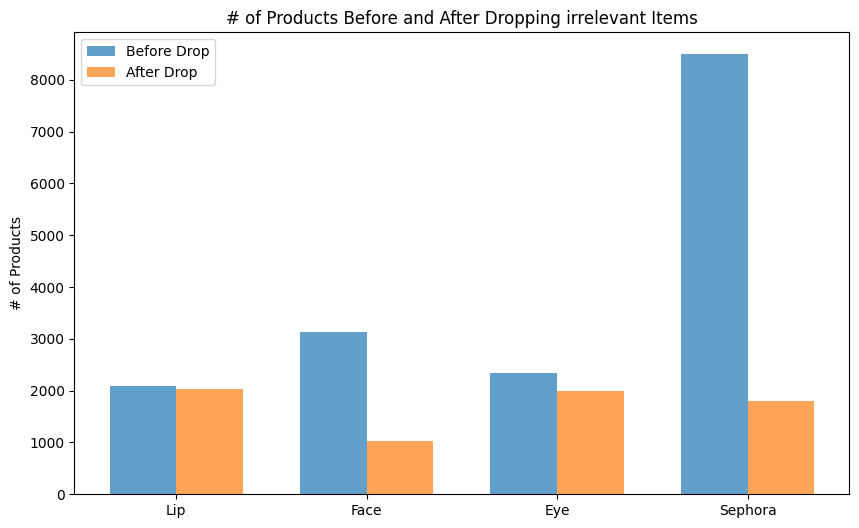

In [68]:
# all 4 datasets
datasets = ["Lip", "Face", "Eye", "Sephora"]

# Before counts
before_counts = [lip_before, face_before, eye_before, sephora_before]

# after counts
after_counts = [len(lipDS), len(faceDS), len(eyeDS), len(sephoraDS)]

# plotting side by side bars
plt.figure(figsize=(10,6))
bar_width = 0.35
x = range(len(datasets))

plt.bar(x, before_counts, width=bar_width, label="Before Drop", alpha=0.7)
plt.bar([i + bar_width for i in x], after_counts, width=bar_width, label="After Drop", alpha=0.7)

plt.xticks([i + bar_width/2 for i in x], datasets)
plt.ylabel("# of Products")
plt.title("# of Products Before and After Dropping irrelevant Items")
plt.legend()
plt.show()



Getting rid of junk phrases from description:

In [ ]:
#nomralize word sulfate
normalize_words = {
    r"\b(sls|sles|sls sles|sles sls|sulfate|sulfates)\b": "sulfates",
    r"\b(paraben|parabens)\b": "parabens"
}

# junk words that need to be removed
junk_phrases = [
    "product description", "description", "directions", "stars", "add", "stars stars",
    "add cart", "cart", "add basket", "basket", "customer", "reviews", "customer reviews",
    "reviews stars", "stars price", "price", "page", "video", "use video", "products video",
    "product unpacked", "video shows", "compares multiple", "setup", "showcases",
    "showcases product", "setup video", "compares", "video compares", "unpacked", "said",
    "safety warning", "use", "product", "apply", "product shows", "shows", "show", "testing",
    "award", "beauty award", "best beauty", "award winner", "best", "warning external",
    "contact", "avoid contact", "safety", "product products", "consumer testing", "women using",
    "using product", "testing women", "previous", "previous previous", "product use",
    "shows product", "community favorite", "community", "consumer", "certified", "approved",
    "makeup accessories", "buying", "buying options", "options", "applicator", "avoid", "ml ml",
    "ml", "fl oz", "formulated", "ingredients", "results", "benefits", "key",
    "key ingredients", "wears", "women using", "lip lip", "using week", "formula",
    "cm", "sephora", "travel", "containing", "ensures", "gently", "device", "scrub",
    "massage", "circular", "clean", "rinse", "steamer", "area", "circular motions",
    "motions", "cushiony", "vivid", "swipe", "infd", "powder", "firms", "firmness",
    "firming", "firmer", "firm", "new", "sleek", "ultra", "captivating", "refillable",
    "case", "core", "providing", "friendly", "improved", "main", "hours", "week",
    "day", "size", "medium", "single", "fuller", "left", "immediate", "tested",
    "face face", "eye eye", "soft soft", "lips lips", "makeup face", "refill",
    "customizable", "reserve", "irritated infected", "eye injured", "injured irritated",
    "italy", "stroke", "innovative", "makeup eye", "vegan natural", "available universally",
    "lipstick available", "wear wear", "wear magnetic", "irresistible shades",
    "irresistible", "available multiple", "black owned", "available", "effortless",
    "certified", "different", "continue", "delivers", "winner", "beauty winner",
    "actual", "good", "years trend", "ahead feet", "beauty delivering", "betraying",
    "budget bold", "betraying budget", "trusted beauty", "looking fabulous",
    "innovations trusted", "difference", "measurement", "manual measurement",
    "picture", "content", "allow", "net", "manual", "complete", "contains", "flawless",
    "sulfates sulfates", "parabens sulfates", "poland", "luxembourg", "makeup palettes",
    "sustainable", "guides", "hr wear", "easy application", "appearance occurs",
    "injured irritated", "vehicle dilute", "irritated infected", "package", "philosophy",
    "trend", "balance", "timeless", "land", "express", "suitable wearers", "wearers",
    "suitable", "york", "wow", "ahead feet", "destination vibrant", "nuanced",
    "nuanced set", "res lifelong", "delivering years", "expert budget", "budget bold",
    "eye patches", "appearance", "radiant", "ophthalmologist", "baby",
    "makeup palettes", "flame direct", "direct heat", "direct", "external eyes", "away",
    "external", "heat sources", "eyes away", "sources", "flame", "using", "neck brand",
    "ideal soft", "revitalization", "gabriel", "past", "mistake proof",
    "principles catalyst", "catalyst developing", "catalyst", "aesthetics functionality",
    "prides integrity", "transparency founded", "developing mistake",
    "integrity transparency", "mistake", "data data", "stamp", "brand",
    "mechanical pencil", "collection", "sets", "crafted","extreme blindness", "lead eye",
    "blindness", "eye scratches","eye scratched", "infected irritated", "eye lead",
    "cosmetics scratched","damage extreme", "bold bright", "bright neutral", "wild imagination",
    "achievability ahead", "achievability", "years forward","thank","face neogenesis",
    "makeup palettes"
]

def clean_description(df, dataset_name):
    df = df.copy()

    df['description'] = df['description'].astype(str)
    df['brand'] = df['brand'].astype(str)

    before_len = df['description'].str.len().sum()


    for pattern, replacement in normalize_words.items():
        df['description'] = df['description'].str.replace(
            pattern, replacement, regex=True, flags=re.IGNORECASE
        )


    for phrase in junk_phrases:
        df['description'] = df['description'].str.replace(
            phrase, "", regex=False, case=False
        )

    # Remove brand names from description
    df['description'] = df.apply(
        lambda row: re.sub(re.escape(row['brand']), '', row['description'], flags=re.IGNORECASE),
        axis=1
    )

    # Clean spacing
    df['description'] = df['description'].apply(
        lambda x: re.sub(r"\s+", " ", x).strip()
    )

    after_len = df['description'].str.len().sum()

    print(f"\n~~~~~ CLEANING DESCRIPTION for {dataset_name} ~~~~~")
    print(f"Total text length before: {before_len}, after: {after_len}")

    return df


# apply
lipDS     = clean_description(lipDS, "Lip")
faceDS    = clean_description(faceDS, "Face")
eyeDS     = clean_description(eyeDS, "Eye")
sephoraDS = clean_description(sephoraDS, "Sephora")


Removing shade from product_name based on 'color' column, so that the user isn't recommended their chosen product in a different shade. Done for all 4 datasets.

Method 1: If value in 'color' column appears in 'product_name', remove it from product name.


In [ ]:
# Removing shade based on color column from product name

def remove_color_from_title(title, color):
    if not isinstance(title, str) or not isinstance(color, str):
        return title

    color = color.strip()
    if color == "":
        return title

    # escape special regex chars in shade names ($ellout)
    escaped_color = re.escape(color)

    # remove exact shade word
    cleaned = re.sub(escaped_color, "", title, flags=re.IGNORECASE)

    # clean leftover chars
    cleaned = re.sub(r"\s{2,}", " ", cleaned)                  # double spaces
    cleaned = re.sub(r"\(\s*\)", "", cleaned)                 # empty ()
    cleaned = re.sub(r"[-–—]\s*$", "", cleaned)               # trailing dash
    cleaned = cleaned.strip(" -–—,")                          # punctuation

    return cleaned


def apply_shade_column_removal(df, dataset_name):
    if "color" not in df.columns:
        print(f"\n{dataset_name}: No color column found")
        return df

    print(f"\n~~~~~ Shade removal for DS {dataset_name}: ~~~~~")

    # apply cleaning
    df["clean_title_color_removed"] = df.apply(
        lambda row: remove_color_from_title(row["product_name"], row["color"]),
        axis=1
    )

    # show before/after examples
    changed = df[df["clean_title_color_removed"] != df["product_name"]]
    print(f"Total rows where shade removal applied: {len(changed)}")

    print("\nBEFORE & AFTER (first 10 changes)\n")
    for idx in changed.head(10).index:
        print("Color :", df.loc[idx, "color"])
        print("Before:", df.loc[idx, "product_name"])
        print("After :", df.loc[idx, "clean_title_color_removed"])
        print()

    # replacingg product_name with cleaned version
    df["product_name"] = df["clean_title_color_removed"]

    return df


lipDS = apply_shade_column_removal(lipDS, "Lip")
faceDS = apply_shade_column_removal(faceDS, "Face")
eyeDS = apply_shade_column_removal(eyeDS, "Eye")
sephoraDS = apply_shade_column_removal(sephoraDS, "Sephora")



~~~~~ Shade removal for DS Lip: ~~~~~
Total rows where shade removal applied: 313

BEFORE & AFTER (first 10 changes)

Color : Toast Of NY
Before: Super Lustrous Lipstick - Toast Of NY
After : Super Lustrous Lipstick

Color : Satin Currant Red - 108
Before: Unlimited Double Touch - Satin Currant Red - 108
After : Unlimited Double Touch

Color : Secret Club
Before: Super Lustrous Lipstick - Secret Club
After : Super Lustrous Lipstick

Color : Rose and Shine
Before: Super Lustrous Lipstick - Rose and Shine
After : Super Lustrous Lipstick

Color : Wine w/ Everything Creme
Before: Super Lustrous Lipstick - Wine w/ Everything Creme
After : Super Lustrous Lipstick

Color : Over The Taupe
Before: Powder Kiss Velvet Blur Slim Moisturizing Matte Lipstick - Over The Taupe
After : Powder Kiss Velvet Blur Slim Moisturizing Matte Lipstick

Color : Laidback Lilac
Before: Super Lustrous Lipstick - Laidback Lilac
After : Super Lustrous Lipstick

Color : Burnt Tangerine - 129
Before: Unlimited Double T

Removing shade from product_name, so that the user isn't recommended their chosen product in a different shade. (Part 2) Done for JUST LIP dataset.

Method 2: Strip shade name after hyphen.

Ex)
* Before: NARS Concealer - Beige
* After: Nars Concealer


In [ ]:
# strip shade from lip dataset by HYPHENS

def strip_shade_lips(name):
    if not isinstance(name, str):
        return name

    # normalize all dash types to a  hyphen -
    normalized = (
        name.replace("–", "-")
            .replace("—", "-")
            .replace("-", "-")
    )

    # if no hyphen left, return name same
    if "-" not in normalized:
        return name

    # SPLIT BY HYPHENS
    parts = [p.strip() for p in normalized.split("-")]

    # FIRST part is the base product name always NOTE!!
    base = parts[0]

    # base is very short, SUS (edge case)
    if len(base) < 3:
        return name

    return base


# APPLY TO LIP DATASET ONLY
lipDS["clean_title_no_shade"] = lipDS["product_name"].apply(strip_shade_lips)

# SHOW BEFORE/AFTER SAMPLE!!!!!!!
changed = lipDS[lipDS["clean_title_no_shade"] != lipDS["product_name"]]
print(f"\nShade removed from {len(changed)} lip rows.\n")

print("~~~~~ BEFORE & AFTER (first 10) ~~~~~\n")
for idx in changed.head(10).index:
    print("Before:", lipDS.loc[idx, "product_name"])
    print("After :", lipDS.loc[idx, "clean_title_no_shade"])
    print()

lipDS["product_name"] = lipDS["clean_title_no_shade"] #put the name back into product_name


Shade removed from 1748 lip rows.

~~~~~ BEFORE & AFTER (first 10) ~~~~~

Before: Stay Put Liquid Lip Longwear Lipstick - Red Flag
After : Stay Put Liquid Lip Longwear Lipstick

Before: Vice Hydrating Lipstick - Uptight
After : Vice Hydrating Lipstick

Before: Word of Mouth Max Comfort Matte Lipstick - RECITE
After : Word of Mouth Max Comfort Matte Lipstick

Before: Retro Matte Liquid Lipstick - Topped With Brandy
After : Retro Matte Liquid Lipstick

Before: Cake Batter Liquid Lipstick - Coffee
After : Cake Batter Liquid Lipstick

Before: Lippie Stix - Caramella
After : Lippie Stix

Before: Velvet Matte Lip Crayon - Ruby
After : Velvet Matte Lip Crayon

Before: Infallible Matte Resistance Liquid Lipstick - 660 First Love
After : Infallible Matte Resistance Liquid Lipstick

Before: Always On Longwear Matte Liquid Lipstick - Girl Gang
After : Always On Longwear Matte Liquid Lipstick

Before: Paint-It Matte Lip Color - Canyon On Fire
After : Paint



Clean/Normalize product_name and brand for deduplication later:

In [ ]:
def clean_text(text):
    #return empty string instead of err
    if pd.isna(text): return ""
    text = text.lower().strip()
    text = text.replace("-", " ").replace("&","and") # replacements
    return text.replace(".","").replace(",","") # remove puncations

# cleaning
for df, name in [(sephoraDS,"Sephora"), (lipDS,"Lip"), (faceDS,"Face"), (eyeDS,"Eye")]:
    df['clean_name']  = df['product_name'].apply(clean_text)
    df['clean_brand'] = df['brand'].apply(clean_text)
    print(f"\n~~~~~ CLEAN TEXT EXAMPLE: {name} ~~~~~")
    print(df[['product_name','brand','clean_name','clean_brand']].head(3))


~~~~~ CLEAN TEXT EXAMPLE: Sephora ~~~~~
                        product_name     brand  \
0               Rose Lip Conditioner     AERIN   
1                  Lip Treatment Oil  Ami Colé   
2  Skin-Enhancing Tinted Moisturizer  Ami Colé   

                          clean_name clean_brand  
0               rose lip conditioner       aerin  
1                  lip treatment oil    ami colé  
2  skin enhancing tinted moisturizer    ami colé  

~~~~~ CLEAN TEXT EXAMPLE: Lip ~~~~~
                            product_name                  brand  \
0                Super Lustrous Lipstick                 Revlon   
1  Stay Put Liquid Lip Longwear Lipstick                 Milani   
2                Vice Hydrating Lipstick  Urban Decay Cosmetics   

                              clean_name            clean_brand  
0                super lustrous lipstick                 revlon  
1  stay put liquid lip longwear lipstick                 milani  
2                vice hydrating lipstick  urban de

Combine all 4 cleaned dataset into 1 dataset.

In [ ]:
combined = pd.concat([sephoraDS, lipDS, faceDS, eyeDS], ignore_index=True)
#making all datasets into one

# Print summary of combined dataset
print("~~~~~ COMBINED DATASET INFO ~~~~~")
print("Combined rows, cols:", combined.shape) #length of new set
print("Rows per source:") # num of rows
print(combined['source'].value_counts()) # preview of new dataset

print("\nSample combined rows:")
print(combined[['product_name','brand','price','source']].head(10))


~~~~~ COMBINED DATASET INFO ~~~~~
Combined rows, cols: (6862, 53)
Rows per source:
source
lip        2035
eye        1995
sephora    1805
face       1027
Name: count, dtype: int64

Sample combined rows:
                                       product_name                    brand  \
0                              Rose Lip Conditioner                    AERIN   
1                                 Lip Treatment Oil                 Ami Colé   
2                 Skin-Enhancing Tinted Moisturizer                 Ami Colé   
3  Lash-Amplifying Volumizing & Lengthening Mascara                 Ami Colé   
4                   Light-Catching Highlighter Balm                 Ami Colé   
5                          Skin-Enhancing Concealer                 Ami Colé   
6              Ultra-Flex Clear Eyebrow Shaping Gel                 Ami Colé   
7          Desert Date Cream Blush & Lip Multistick                 Ami Colé   
8         Brow Wiz Ultra-Slim Precision Brow Pencil  Anastasia Beverly Hills 

**Remove duplicate products** from combined dataset:

In [ ]:

print("\n~~~~~ CHECKING FOR DUPLICATE PRODUCTS ACROSS DATASETS ~~~~~")

#marking rows that are duplicates
dup_mask = combined.duplicated(subset=["clean_brand", "clean_name"], keep=False)
duplicates = combined[dup_mask].copy() #creating a subset for the duplicates

if len(duplicates) == 0:
    print("No exact duplicates found!")
else:
    print(f"Found {len(duplicates)} duplicate rows:")
    cols_to_show = [
        "clean_brand",
        "clean_name",
        "product_name",
        "brand",
        "price",
        "source"
    ]

    #printing duplicates sorted
    print(
        duplicates[cols_to_show]
        .sort_values(["clean_brand", "clean_name", "price"])
        .reset_index(drop=True)
    )

    #counting duplicates per product
    print("\n~~~~~ DUPLICATE GROUP COUNTS ~~~~~")
    print(
        duplicates.groupby(["clean_brand", "clean_name"])
                  .size()
                  .sort_values(ascending=False)
    )


# deleting duplicates
combined_unique = (
    combined.sort_values('price')
            .drop_duplicates(subset=['clean_brand','clean_name'], keep='first')
            .reset_index(drop=True)
)


#printing for debugginng
print("\n~~~~~ AFTER DEDUPLICATION BY (clean_brand, clean_name) ~~~~~")
print("Combined unique rows, cols:", combined_unique.shape)
print("Rows per source (unique):")
print(combined_unique['source'].value_counts())
print("combined_unique columns    ", list(combined_unique.columns), "...")



~~~~~ CHECKING FOR DUPLICATE PRODUCTS ACROSS DATASETS ~~~~~
Found 2772 duplicate rows:
     clean_brand                                         clean_name  \
0     3r factory  brow definer   3r factory eye brow pencils for...   
1     3r factory  brow definer   3r factory eye brow pencils for...   
2     about face                       cherry pick lip color butter   
3     about face                       cherry pick lip color butter   
4     about face                       cherry pick lip color butter   
...          ...                                                ...   
2767  youngblood  youngblood on point brow defining pencil   wom...   
2768      zeesea  zeesea egypt eyeshadow palette the british mus...   
2769      zeesea  zeesea egypt eyeshadow palette the british mus...   
2770   zuzu luxe               zuzu luxe vegan liquid eyeliner 1 oz   
2771   zuzu luxe               zuzu luxe vegan liquid eyeliner 1 oz   

                                           product_name    

**Visualization**: Comparing total number of products dropped overall:

BEFORE = The combined number of rows of the original 4 datasets, before any cleaning

AFTER = The number of rows in the combined dataset AFTER cleaning AND deduplication.


~~~~~ DEDUPLICATION SUMMARY ~~~~~
Total # of products across all 4 original datasets: 16066
Total # of products after data cleanup and deduplcation:  4523
Rows removed as duplicates:      11543


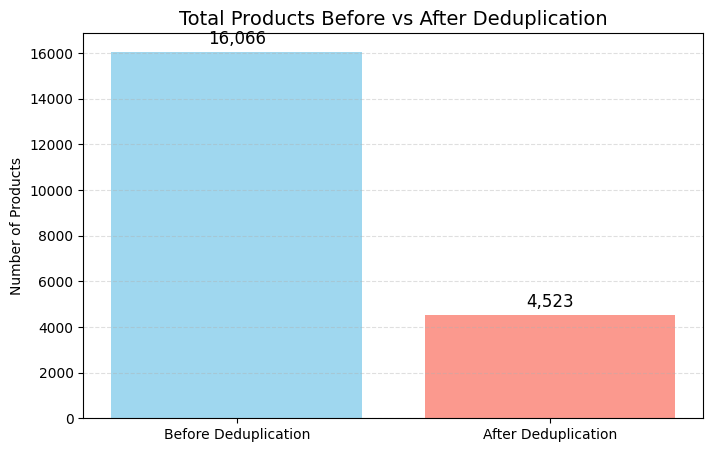

In [ ]:
# Visualization OVERALL NUMBER OF ROWS DROPPED

# BEFORE = total rows of OG 4 datasets BEFORE any cleaning
total_before = lip_before + face_before + eye_before + sephora_before

# AFTER = number of rows in COMBINED dataset AFTER deduplication
total_after = len(combined_unique)

print("\n~~~~~ DEDUPLICATION SUMMARY ~~~~~")
print(f"Total # of products across all 4 original datasets: {total_before}")
print(f"Total # of products after data cleanup and deduplcation:  {total_after}")
print(f"Rows removed as duplicates:      {total_before - total_after}")

# Visualization
labels = ["Before Deduplication", "After Deduplication"]
values = [total_before, total_after]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, values, color=["skyblue", "salmon"], alpha=0.8)

# adding numbers on bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + max(values)*0.01,
        f"{height:,}",
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.title("Total Products Before vs After Deduplication", fontsize=14)
plt.ylabel("Number of Products")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


**Visualization Analysis:** So many products were dropped because there were many duplicate products, products missing vital information, and non-makeup items (brushes, skincare, etc).

Limit combined dataset down to needed columns:

In [ ]:
#limit it down to necessary rows
keep_cols = [
    "product_name",
    "brand",
    "price",
    "category_1",
    "category_2",
    "category_3",
    "highlights",
    "description",
    "ingredients",
    "source" #which of the 4 datasets a product comes from
]

#reducing datatset to just important cols
combined_unique = combined_unique[keep_cols]

#output to csv
output_path = "combined_unique_products.csv"
combined_unique.to_csv(output_path, index=False)
print(f"Saved final combined dataset to --> {output_path}")

Saved final combined dataset to --> combined_unique_products.csv


### 2. TFIDF

Captures features of descriptions and ingredients in products.

In [ ]:
# TFIDF VECTORIZATION

# loading clean dataset
df = pd.read_csv("combined_unique_products.csv")
print("Loaded dataset:", df.shape)

# cleaning text just for TFIDF
def clean_text_TFIDF(s):
    if pd.isna(s):
        return ""
    s = s.lower()
    s = re.sub(r"[^a-z\s]", " ", s)       #remove numbers, fixes features
    s = re.sub(r"\s+", " ", s)           # collapse spaces
    return s.strip()

#Applying cleaning to the description and ingredients cols
df["desc_clean"] = df["description"].apply(clean_text_TFIDF)
df["ing_clean"]  = df["ingredients"].apply(clean_text_TFIDF)

print("\n~~~~~ CLEANED TEXT PREVIEW ~~~~~")
print(df[["product_name","desc_clean","ing_clean"]].head(5))


Loaded dataset: (4523, 10)

~~~~~ CLEANED TEXT PREVIEW ~~~~~
                                        product_name  \
0  Eye Concealer for Mature Skin Concealer Concea...   
1  wet n wild Color Icon Kohl Eyeliner Pencil, Ri...   
2  Powder Sponge,Soft Face Powder Puff - Makeup B...   
3  7 Color Highlight Stick Brightening Stick Ster...   
4  Leg Makeup No Transfer over Up Makeup Leg And ...   

                                          desc_clean  \
0  eye concealer for mature skin concealer concea...   
1  sniff were gonna get all sentimental here we r...   
2  get perfect cosmetic foundation with ease our ...   
3  color highlight stick brightening stick stereo...   
4  leg makeup no transfer cover up makeup leg and...   

                                           ing_clean  
0                                                     
1  ingredients beeswax cire d abeille copernicia ...  
2                                                     
3                                            

Runs TFIDF for Description

In [ ]:
# ~~~~~~~~~~~TF-IDF for DESCRIPTION~~~~~~~~~~~
tfidf_desc = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1,2),       # unigrams ('hydrating') + bigrams ("full coverage')
    stop_words="english"
)

tfidf_desc_matrix = tfidf_desc.fit_transform(df["desc_clean"])
print("\nTF-IDF Description matrix shape:", tfidf_desc_matrix.shape)



TF-IDF Description matrix shape: (4523, 3000)


Runs TFIDF For Ingredients

In [ ]:
# ~~~~~~~~~~~TF-IDF for INGREDIENTS~~~~~~~~~~~
tfidf_ing = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1,1),       # bug fixed 12/8: unigrams for ingredients only
    stop_words="english"
)

tfidf_ing_matrix = tfidf_ing.fit_transform(df["ing_clean"])
print("TF-IDF Ingredients matrix shape:", tfidf_ing_matrix.shape)

TF-IDF Ingredients matrix shape: (4523, 3000)


L2 Normalization

In [ ]:
# L2 normalization
desc_norm = normalize(tfidf_desc_matrix)
ing_norm  = normalize(tfidf_ing_matrix)

print("\nNormalized shapes:")
print("desc_norm:", desc_norm.shape)
print("ing_norm: ", ing_norm.shape)


Normalized shapes:
desc_norm: (4523, 3000)
ing_norm:  (4523, 3000)


Combining Embedding Weights (Description and Ingredients) + Save TFIDF results

In [ ]:
# combined embedding weights
W_DESC = 0.65
W_ING  = 0.35

final_vectors = W_DESC * desc_norm + W_ING * ing_norm #description weight and ingredient weight


print("\nFinal combined embedding shape:", final_vectors.shape)


# Save matrices to reuse

sp.save_npz("tfidf_desc_matrix.npz", tfidf_desc_matrix)
sp.save_npz("tfidf_ing_matrix.npz", tfidf_ing_matrix)
sp.save_npz("final_vectors.npz", final_vectors)

print("\nSaved TF-IDF matrices :)")


Final combined embedding shape: (4523, 3000)

Saved TF-IDF matrices :)


TFIDF Debugging below to inspect results:

In [ ]:
# -----------------debugging, checking---------------
print("desc:", tfidf_desc_matrix.shape)
print("ing:", tfidf_ing_matrix.shape)
print("final:", final_vectors.shape)
# preview extracted vocabulary
print("\nFeatures:")
print("Description features (sample):", tfidf_desc.get_feature_names_out()[:50])
print("\nIngredients features (sample):", tfidf_ing.get_feature_names_out()[:50])

#TEST: shows which of the 3000 features appear in a product's description / ingredient
i = 0  # product index, adjustable
print(f"\n~~~~~~~~ TFIDF Info on PRODUCT {i} ~~~~~~~~")
print(f"Product {i} Name: \n --> {df.iloc[i]['product_name']}")
print(f"\nDescription Features:")
row = tfidf_desc_matrix[i]
cols = row.nonzero()[1]  # which words appear in this description
words = tfidf_desc.get_feature_names_out()[cols]
print(words)
print(f"\nIngredient features:")
row_ing = tfidf_ing_matrix[i]
cols_ing = row_ing.nonzero()[1]
words_ing = tfidf_ing.get_feature_names_out()[cols_ing]
print(words_ing)

#Check L2 Norm
i = 0
print("\nL2 Norm: \nDescription L2 norm:", np.linalg.norm(desc_norm[i].toarray()))
print("Ingredients L2 norm:", np.linalg.norm(ing_norm[i].toarray()))
if np.linalg.norm(ing_norm[i].toarray()) == 0:
    print(" --> Ingredients don't exist for this product")
#empty ingredients: L2 norm = 0. Full: L2 = 1.


#See what TFIDF says is similar
sims = cosine_similarity(desc_norm[i], desc_norm)[0]
# sort similarity highest to lowest
top = sims.argsort()[::-1][1:11]   # skip itself by starting at [1]
print("\nSimilar products using cosine similarity: ")
for idx in top:
    print(f"{sims[idx]:.3f} - {df.iloc[idx]['product_name']}")


desc: (4523, 3000)
ing: (4523, 3000)
final: (4523, 3000)

Features:
Description features (sample): ['ability' 'able' 'abs' 'absorb' 'absorption' 'accelerate' 'accentuate'
 'accessibility' 'accessibility offer' 'accessible' 'accessible beauty'
 'accessories' 'according' 'accurate' 'acetate' 'achieve'
 'achieve perfect' 'achieved' 'achieving' 'acid' 'acid hydrating'
 'acid liquid' 'acid vitamin' 'acids' 'acne' 'acrylates' 'action'
 'activate' 'activated' 'active' 'active wear' 'acts' 'adhere' 'adheres'
 'adjust' 'advanced' 'aesthetics' 'aesthetics functionality' 'affordable'
 'age' 'agents' 'ages' 'aging' 'agreed' 'ahead' 'ahead feet' 'air'
 'air cushion' 'air dry' 'airbrushed']

Ingredients features (sample): ['abeille' 'abelmoschus' 'abs' 'abyssinica' 'ac' 'acacia' 'acai' 'acer'
 'acerola' 'acerosa' 'acetal' 'acetate' 'acetatephenoxyethanolcaprylyl'
 'acetatesodium' 'acetone' 'acetum' 'acetyl' 'acetylated' 'achieve'
 'achillea' 'acid' 'acidalumina' 'acidc' 'acidcera' 'acids' 'acis'
 'a

### 3. SVD

Takes TFIDF vectors (3000 dim vector per product) and compresses them (250 dim vector per product) while keeping meaning.
Makes matches better (TFIDF too broad)

Running SVD below:

In [ ]:
print("Input TF-IDF Combined Vector Shape:", final_vectors.shape)

# reduced dimension
REDUCED_DIM = 250

svd_model = TruncatedSVD(
    n_components=REDUCED_DIM,
    n_iter=10,
    random_state=42
)

print(f"\nFitting SVD with {REDUCED_DIM} components:")
svd_vectors = svd_model.fit_transform(final_vectors)

print("\n~~~~~ SVD RESULTS ~~~~~")
print("SVD output shape:", svd_vectors.shape)

print("\n\033[92mTotal explained variance (how much meaning kept from TFIDF): ")
print(f"{svd_model.explained_variance_ratio_.sum() * 100}% \033[0m")

# saving SVD vectors + model
np.save("svd_vectors.npy", svd_vectors)

# saving components for later cosine similarity
np.save("svd_components.npy", svd_model.components_)


Input TF-IDF Combined Vector Shape: (4523, 3000)

Fitting SVD with 250 components:

~~~~~ SVD RESULTS ~~~~~
SVD output shape: (4523, 250)

Total explained variance (how much meaning kept from TFIDF): 
65.2852058658% 


**Inspecting SVD Components:**

In [ ]:
# getting combined vocabulary from both TF-IDFs
desc_vocab = list(tfidf_desc.get_feature_names_out())
ing_vocab  = list(tfidf_ing.get_feature_names_out())

# combined vocabulary index since we did desc_norm + ing_norm
combined_vocab = desc_vocab + ing_vocab   # 3000 + 3000 = 6000
components = svd_model.components_

def print_top_words(component_idx, n=20):
    comp = components[component_idx]
    # grab indices of top weights
    top_indices = comp.argsort()[::-1][:n]
    print(f"\n~~~~~ SVD Component #{component_idx} — Top {n} Words ~~~~~")
    for idx in top_indices:
        print(f"{combined_vocab[idx]}   ({comp[idx]:.4f})")

# showcasing first 100 SVD components, 20 terms per component
for i in range(100):
    print_top_words(i, n=20)



~~~~~ SVD Component #0 — Top 20 Words ~~~~~
cosmetic eye   (0.4374)
makeup   (0.2254)
finish   (0.1765)
free   (0.1299)
vegan   (0.1218)
lead eye   (0.1212)
wearing   (0.1183)
long   (0.1183)
long wearing   (0.1183)
easy glide   (0.1106)
mascara   (0.1044)
isostearate   (0.1029)
matte   (0.0996)
peut   (0.0980)
pc   (0.0932)
settle   (0.0911)
gripping   (0.0893)
parabens   (0.0880)
way   (0.0873)
cruelty   (0.0870)

~~~~~ SVD Component #1 — Top 20 Words ~~~~~
mascara   (0.3258)
packing   (0.3210)
international   (0.2469)
lashes   (0.1397)
skin   (0.1392)
eye   (0.1094)
brush   (0.1088)
lash   (0.1041)
color   (0.0932)
look   (0.0904)
volume   (0.0884)
smooth   (0.0841)
eyes   (0.0806)
color skin   (0.0721)
eyeliner   (0.0695)
pencil   (0.0642)
brows   (0.0631)
step   (0.0608)
face   (0.0602)
tip   (0.0586)

~~~~~ SVD Component #2 — Top 20 Words ~~~~~
packing   (0.5668)
international   (0.2580)
skin   (0.2085)
foundation   (0.1234)
makeup   (0.1067)
finish   (0.0980)
sponge   (0.0887)


Visualization of SVD Variance:

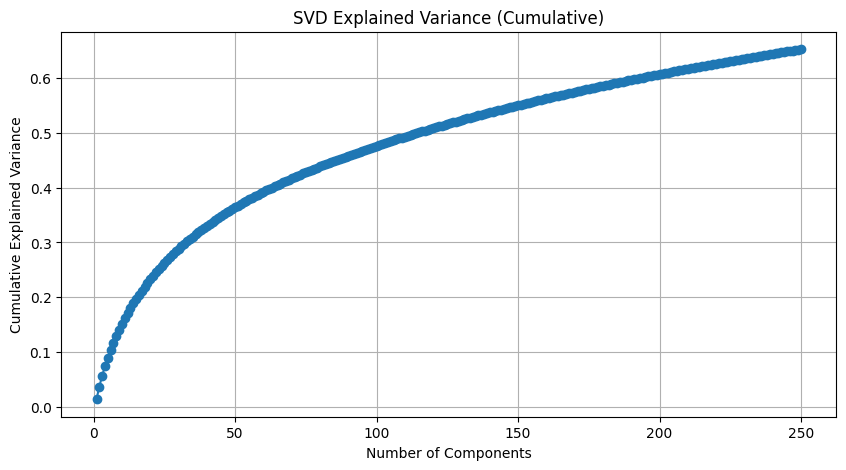

In [ ]:

# explained variance ratios from the SVD model
var = svd_model.explained_variance_ratio_
cum_var = np.cumsum(var)

plt.figure(figsize=(10,5))
plt.plot(range(1, len(var)+1), cum_var, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("SVD Explained Variance (Cumulative)")
plt.grid(True)
plt.show()


**SVD Visual Analysis**

The first 50 SVD Components explain most of the variance, meaning they capture a lot of semantic information about the data.

As the slope begins to flatten, the next SVD Components capture more subtle patterns.

There is a smooth  upward shape and no straight plateaus which is good, meaning each component still contributes useful semantic meaning as the curve trails off

### 4. PCA (Visualization)

Running PCA to help later with cluster visualization using K-Means.

In [ ]:
#running PCA on SVD vectors to show embedding space
pca = PCA(n_components=2, random_state=42)
pca_coords = pca.fit_transform(svd_vectors)

print("PCA output shape:", pca_coords.shape)
print("Explained variance by PCA components:", pca.explained_variance_ratio_)


PCA output shape: (4523, 2)
Explained variance by PCA components: [0.0437005  0.03213544]


PCA is a combination of weighted SVD Vectors.
PCA Component 1 and 2 keep the biggest variance directions.

### 5. K-Means

Groups products in categories/clusters (i.e lippies, soft, creamy, matte, foundation, blush) etc.



Running Kmeans below:

In [ ]:
#running Kmeans

# number of clusters
K = 50

kmeans = KMeans(
    n_clusters=K,
    n_init=20,
    random_state=42
)

cluster_labels = kmeans.fit_predict(svd_vectors)


**Analysis**: 50 Clusters was the sweet spot; not too many clusters so that theres redundancy, and not too little that unrelated products are mixed together.

Visualizing Kmeans clusters on PCA:

Number of products in each cluster: [253 129  81  79 143  54 184 283 227 682 109 114  22  40  79   7  33 113
  62  45  34  41  41  40   7  18  18 303  51  59  66 106  42  10  27 153
  63  51  31  40  67  20  44   7  73  52 269  26   4  21]


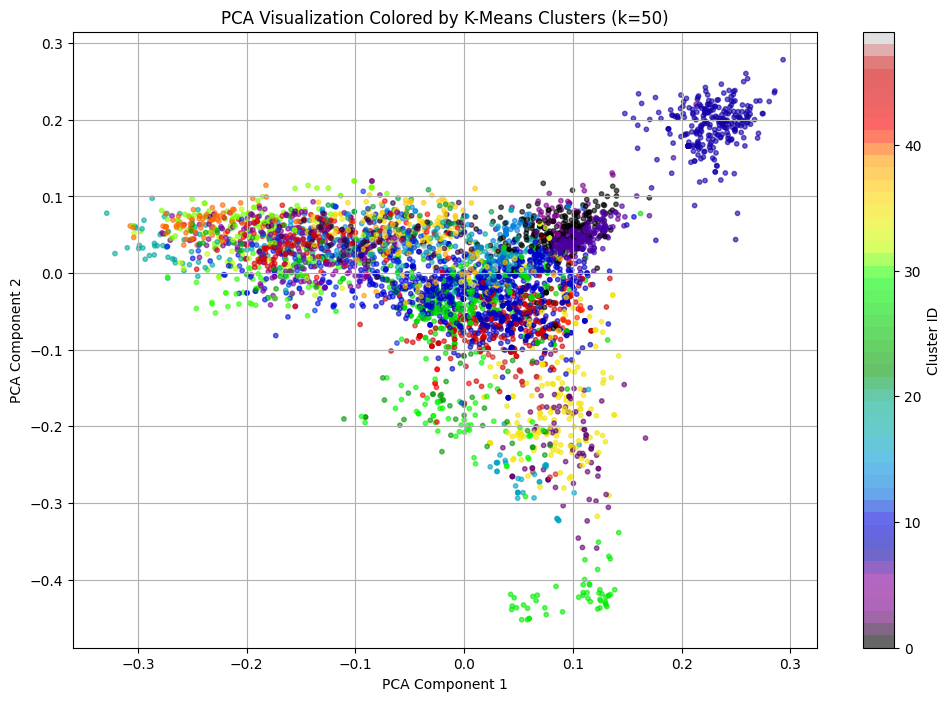

In [ ]:
df["cluster"] = cluster_labels

print("Number of products in each cluster:", np.bincount(cluster_labels))

# one color per cluster
cmap = plt.colormaps.get_cmap("nipy_spectral").resampled(K)

# pca scatter plot
plt.figure(figsize=(12,8))
scatter = plt.scatter(
    pca_coords[:,0],
    pca_coords[:,1],
    c=cluster_labels,
    cmap=cmap,
    s=10,
    alpha=0.6
)

plt.title(f"PCA Visualization Colored by K-Means Clusters (k={K})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.show()


**Analysis**

Can see cluster vaguely because PCA Visual is limited to 2 axis out of 250 SVD dimensions.

Looking at the cluster information directly (below cell) show a good seperation of product types and functionalities, meaning the current number of clusters is good.


Below: Inspecting what each cluster actually represents / contains.

In [ ]:
# inspecting what each cluster represents

for c in range(K):
    print(f"\n~~~~~ Cluster {c} Sample Products =~~~~~")

    cluster_rows = df[df["cluster"] == c]

    # choose up to 5 rows only if available
    n = min(5, len(cluster_rows))

    if n == 0:
        print("No products in this cluster")
        continue

    sample = cluster_rows.sample(n, random_state=42)

    print(sample[["product_name", "brand", "category_1"]])



~~~~~ Cluster 0 Sample Products =~~~~~
                                           product_name           brand  \
3602  Veil Cosmetics Complexion Fix Liquid Foundatio...  Veil Cosmetics   
30    Delicate Angled Concealer Brush Synthetic Fibe...         YiNLuax   
784   MCoBeauty Waterproof & Smudge Proof Eye Define...       MCoBeauty   
3504  VITA LIBERATA Beauty Blur 30ml & Brush Bundle,...   VITA LIBERATA   
1378  Witch's Pouch Sparkle Eyeshadow Powder Glitter...   Witch's Pouch   

                  category_1  
3602                  Beauty  
30                    Beauty  
784   Beauty & Personal Care  
3504                  Beauty  
1378  Beauty & Personal Care  

~~~~~ Cluster 1 Sample Products =~~~~~
                                           product_name          brand  \
3356                               Skin Concealer Stick    Bobbi Brown   
3161           Dualist Matte and Illuminating Concealer  Wander Beauty   
2723   Born This Way Ethereal Light Smoothing Concealer      

### 5.a Get KMeans Cluster Names

Creating a name for each K-means cluster.

Reason: The user needs to know why they were recommended a product. These cluster names act as descriptions/reasons so the user knows WHY certain products are recommended. Displayed in the UI.

In [ ]:
# Helper function: extracts top TF-IDF terms for each cluster
def get_top_terms_for_cluster(tfidf_matrix, labels, vectorizer, cluster_id, top_n=20):
    idx = np.where(labels == cluster_id)[0]
    if len(idx) == 0:
        return []

    cluster_sum = tfidf_matrix[idx].sum(axis=0)
    cluster_sum = np.asarray(cluster_sum).ravel()

    top_idx = cluster_sum.argsort()[::-1][:top_n]
    terms = vectorizer.get_feature_names_out()

    return [(terms[i], cluster_sum[i]) for i in top_idx]


In [ ]:
# Helper function: Creates cluster names for each cluster by combining terms
def generate_cluster_name(top_terms):
    if not top_terms:
        return "Unknown Cluster"
    words = [w for w,_ in top_terms[:15]]
    return ", ".join(words).title()


In [ ]:
# Generate names AND show top words
cluster_name_map = {}

for cid in range(K):
    top_words = get_top_terms_for_cluster(  #helper function
        tfidf_desc_matrix,  # TFIDF matrix for descriptions
        cluster_labels,     # KMeans labels
        tfidf_desc,         # TFIDF vectorizer
        cid
    )

    name = generate_cluster_name(top_words) #helper function
    cluster_name_map[cid] = name #cluster names stored here

    print(f"\n~~~~~ Cluster #{cid} — \nCluster Name: {name} ~~~~~ \nScores: ")
    for w, score in top_words[:15]: #top 15 words
        print(f"{w:20s}  {score:.4f}")



~~~~~ Cluster #0 — 
Cluster Name: Skin, Foundation, Cream, Natural, Bb, Makeup, Concealer, Coverage, Brush, Face, Light, Cc, Perfect, Cc Cream, Finish ~~~~~ 
Scores: 
skin                  37.1712
foundation            15.4193
cream                 14.7746
natural               11.8248
bb                    10.6491
makeup                9.9110
concealer             9.9076
coverage              9.7219
brush                 9.5631
face                  8.4088
light                 8.2195
cc                    7.3186
perfect               7.1257
cc cream              6.8426
finish                6.7483

~~~~~ Cluster #1 — 
Cluster Name: Coverage, Wearing Coverage, Finish, Long Wearing, Wearing, Foundation, Concealer, Liquid, Natural Finish, Long, Finish Liquid, Hydrating, Vegan, Natural, Finish Long ~~~~~ 
Scores: 
coverage              23.0374
wearing coverage      15.5104
finish                15.3612
long wearing          15.2355
wearing               15.1233
foundation            13.

### 6. Cosine Sim + UI Backend

Actual dupe finder logic below (UI Backend).

Get's user's product, find the K-Means cluster it belongs too, ranks by cosine similarity within that cluster, and return top dupes.

In [ ]:
def find_dupes(product_name, df, svd_vectors, top_n=10):
    #  find product
    matches = df.index[df["product_name"] == product_name].tolist()
    if not matches:
        print(f"Product '{product_name}' not found :(")
        return None

    product_idx = matches[0]
    row = df.loc[product_idx]

    target_brand = row["brand"]
    target_cluster = row["cluster"]

    # print cluster name that generate_cluster_name() built
    cluster_name = cluster_name_map.get(target_cluster, "Unknown Cluster")

    print(f"User's Product: \n  - {row['product_name']}")
    print(f"\nBrand: {target_brand}")
    print(f"\nCluster: #{target_cluster} — {cluster_name}")

    # get candidates in same cluster, diff brand
    cluster_indices = df.index[
        (df["cluster"] == target_cluster) &
        (df["brand"] != target_brand)
    ].tolist()

    if len(cluster_indices) == 0:
        print("\nNo other-brand items inside this cluster.")
        return None

    # cosine similarity
    sims = cosine_similarity(
        svd_vectors[product_idx].reshape(1, -1),
        svd_vectors[cluster_indices]
    )[0]

    sorted_idx = np.argsort(sims)[::-1][:top_n]
    best_indices = [cluster_indices[i] for i in sorted_idx]
    best_scores  = sims[sorted_idx]

    # build results
    results = []
    for idx, score in zip(best_indices, best_scores):
        shared = get_shared_features_combined(
            product_idx, idx,
            tfidf_desc_matrix, tfidf_desc,
            tfidf_ing_matrix,  tfidf_ing,
            top_n=8
        )
        results.append({
            "product_name": df.loc[idx, "product_name"],
            "brand": df.loc[idx, "brand"],
            "price": df.loc[idx, "price"],
            "similarity": round(score, 4),
            "shared_features": shared
        })

    return pd.DataFrame(results)


Returns shared TFIDF features between user's target product and all recommendations/dupes:

> Reason: The user will know what qualities their product and the dupes share.



In [ ]:
def get_shared_features_combined(target_idx, compare_idx,
                                 tfidf_desc, tfidf_desc_vectorizer,
                                 tfidf_ing,  tfidf_ing_vectorizer,
                                 top_n=10):

    # description
    d1 = tfidf_desc[target_idx].toarray().ravel()
    d2 = tfidf_desc[compare_idx].toarray().ravel()
    shared_desc = d1 * d2

    desc_vocab = tfidf_desc_vectorizer.get_feature_names_out()
    desc_indices = shared_desc.argsort()[::-1]

    desc_terms = []
    for i in desc_indices:
        if shared_desc[i] > 0:
            desc_terms.append(desc_vocab[i])
        if len(desc_terms) >= top_n:
            break

    #  ingredients
    i1 = tfidf_ing[target_idx].toarray().ravel()
    i2 = tfidf_ing[compare_idx].toarray().ravel()
    shared_ing = i1 * i2

    ing_vocab = tfidf_ing_vectorizer.get_feature_names_out()
    ing_indices = shared_ing.argsort()[::-1]

    ing_terms = []
    for i in ing_indices:
        if shared_ing[i] > 0:
            ing_terms.append(ing_vocab[i])
        if len(ing_terms) >= top_n:
            break

    # Combine & remove duplicates
    combined = list(dict.fromkeys(desc_terms + ing_terms))

    return combined[:top_n]


### 7. User Selects Product, UI

UI For Makeup Recommender

In [ ]:
# ui
product_dropdown = widgets.Combobox(
    placeholder='Type a product name...',
    options=sorted(df['product_name'].unique().tolist()),
    description='Product:',
    ensure_option=False,
    continuous_update=False,
    layout=widgets.Layout(width='600px')
)

search_button = widgets.Button(
    description='Find Dupes',
    button_style='primary',
    tooltip='Search for similar products'
)

output_area = widgets.Output()

# button click callback
def on_search_clicked(b):
    output_area.clear_output()

    product = product_dropdown.value

    with output_area:
        # Validate selection
        if product not in df['product_name'].values:
            print("Product not found. Please select a valid name.")
            return

        print(f"Searching for dupes of: \n  - {product}\n")

        # call dupe finder function backend
        results = find_dupes(product, df, svd_vectors, top_n=10)

        if results is None or len(results) == 0:
            print("No matching dupes found.")
            return

        # format table, display
        display(
            HTML(
                results.to_html(index=False)
            )
        )

# connect button to callback
search_button.on_click(on_search_clicked)

# Display UI
display(product_dropdown, search_button, output_area)


Combobox(value='', continuous_update=False, description='Product:', layout=Layout(width='600px'), options=('#B…

Button(button_style='primary', description='Find Dupes', style=ButtonStyle(), tooltip='Search for similar prod…

Output()

NOTE: Github cannot preview UIs. Codebench previews UI properly. 